# Say Hello to Actor Critic

![좋은것](https://cdn-media-1.freecodecamp.org/images/1*e1N-YzQmJt-5KwUkdUvAHg.png)

[보면 좋은 것 1](https://rebornhugo.github.io/assets/images/post_images/Policy%20Gradient%20Methods/1522575360144.png)<br>
[나중에 보면 좋은 것](https://hal.inria.fr/hal-00840470/document)

1. Actor는 Policy를 만든다.
2. Critic은 현재 state의 가치(or 그 state에서의 action의 가치)를 평가한다


# 준비

In [1]:
%%time
## 약 25초 ~30초 소요
!pip install pyvirtualdisplay 
!apt-get install -y xvfb python-opengl ffmpeg
!pip install gym
!pip install box2d-py
#!pip install pyglet==1.3.2
!pip install pyglet

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
xvfb is already the newest version (2:1.19.6-1ubuntu4.8).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.
CPU times: user 70.2 ms, sys: 35.1 ms, total: 105 ms
Wall time: 12.6 s


In [2]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

In [3]:
display = Display(visible=0, size=(1400, 900))
display.start()

In [4]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[-1]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

# CartPole-v1

In [5]:
env = wrap_env(gym.make("CartPole-v1"))
print('observation space:', env.observation_space)
print('action space:', env.action_space)

state = env.reset()
for t in range(1000):
    action = env.action_space.sample() # your agent here (this takes random actions)
    env.render()
    observation, reward, done, info = env.step(action)
    if done: 
      break;
            
print('steps: ', t)
env.close()
show_video()

observation space: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
action space: Discrete(2)
steps:  27


In [6]:
print("state 수는? : ", env.observation_space.shape)
print("action 수는? : ", env.action_space.n)

state 수는? :  (4,)
action 수는? :  2


# Actor Critic Network를 만들자!

1. 한 episode가 끝이 나야 학습이 진행이 되는 네트워크를 구성할 것이다.

In [7]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

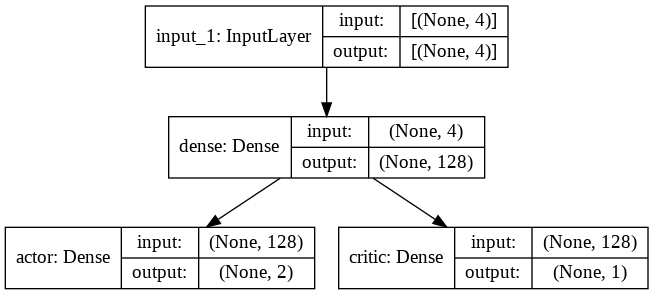

In [8]:
keras.backend.clear_session()

state_layer = layers.Input(shape=env.observation_space.shape)
common = layers.Dense(128, activation = 'relu')(state_layer)
action = layers.Dense(env.action_space.n, activation = 'softmax', name='actor')(common)
critic = layers.Dense(1, name='critic')(common)
model = keras.models.Model(inputs = state_layer, outputs=[action, critic])

plot_model(model, show_shapes=True)

# Compile

**두 가지의 loss를 알아야 한다.**
1. actor의 loss : return - critic_value와   actor(policy, actio확률들)의 crossentropy
    * .fit()에 넣어줄 output이 return - critic_value가 되는것!
2. critic의 loss : critic_value와 return의 huber loss!
    * .fit()에 넣어줄 output이 return이 되는 것!

In [9]:
adam = tf.keras.optimizers.Adam(0.01)
cce = tf.keras.losses.CategoricalCrossentropy(
    reduction=tf.keras.losses.Reduction.SUM)
huber = tf.keras.losses.Huber()

In [10]:
model.compile(optimizer = tf.keras.optimizers.Adam(0.01),
              loss={'actor':cce, 'critic':huber})

# 한 Episode가 끝나면 학습을 시키는 방법!

**Return을 Normalize할 수 있다!**

## 일단 actor 네트워크를 믿고 한 에피소드에 필요한 내용들을 기록한다.

In [11]:
num_actions = env.action_space.n
state_history = []
action_history = []
critic_history = []
rewards_history = []

env = wrap_env(gym.make("CartPole-v1"))
s0 = env.reset()
episode_reward = 0

for i in range(10000):
    s0 = s0.reshape([1,-1])
    state_history.append(s0)
    policy_s0, critic_s0 = model.predict(s0)
    critic_history.append(critic_s0[0,0])

    a0 = np.random.choice(num_actions, p = policy_s0.reshape(-1))
    a0_dummy = np.eye(num_actions)[a0]
    action_history.append(a0_dummy)
 
    s1, r1, done, _ = env.step(a0)
    rewards_history.append(r1)

    s0 = s1

    if done :
        env.close()
        # show_video()
        break

## return을 계산한다.
**Normalize를 하자!**

In [12]:
gamma = 0.99  # Discount factor for past rewards
num_inputs = 4
num_actions = 2
eps = np.finfo(np.float32).eps.item()  ## 매우 작은 수.

In [13]:
returns = []
Gt = 0
for r in rewards_history[::-1] : # 거꾸로 뽑는다.
    Gt = r + gamma*Gt
    returns.insert(0,  Gt) # append를 0번 인덱스부터 하는 것!

In [14]:
# Normalize
returns = np.array(returns)
returns = (returns - np.mean(returns)) / (np.std(returns) + eps)
returns = returns.tolist()

## .fit()에 넣을 x, y를 준비한다.

1. state (x): [None, 4] 모양 주의
2. actor_r (y1): [None, 2] return-critic 과 action dummy 이용
3. critic_r (y2): [None, 1] return

In [15]:
state = np.vstack(state_history)
state.shape

(20, 4)

In [16]:
action_dummy = np.vstack(action_history)
returns = np.array(returns).reshape([-1,1])
critic = np.array(critic_history).reshape([-1,1])

action_dummy.shape, returns.shape, critic.shape

((20, 2), (20, 1), (20, 1))

In [17]:
actor_r = (returns-critic)*action_dummy
actor_r.shape

(20, 2)

## 한 에피소드로 학습을 시킨다.

In [18]:
model.fit(state, [actor_r, returns], verbose=0 ,epochs=1, batch_size=10000) # 한번에 학습을 하도록

## 이제 아래에 모아서 2000 episod 학습시켜보자! (중간에 중단 시킬 것)

=== 10번째 episode, rewards 합 : 14.0 ====
=== 20번째 episode, rewards 합 : 34.0 ====


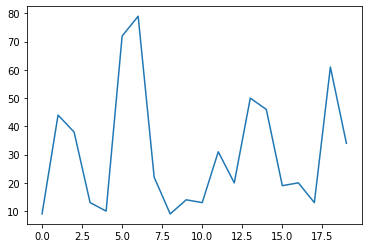

KeyboardInterrupt: ignored

In [20]:
n_episode = 2000
cum_r = []

for episode in range(n_episode):
    

    ### 한 episode 그대로 겪고 history를 남기도록.
    num_actions = env.action_space.n
    state_history = []
    action_history = []
    critic_history = []
    rewards_history = []

    env = wrap_env(gym.make("CartPole-v1"))
    s0 = env.reset()
    episode_reward = 0

    for i in range(10000):
        s0 = s0.reshape([1,-1])
        state_history.append(s0)
        policy_s0, critic_s0 = model.predict(s0)
        critic_history.append(critic_s0[0,0])

        a0 = np.random.choice(num_actions, p = policy_s0.reshape(-1))
        a0_dummy = np.eye(num_actions)[a0]
        action_history.append(a0_dummy)
    
        s1, r1, done, _ = env.step(a0)
        rewards_history.append(r1)

        s0 = s1

        if done :
            env.close()
            cum_r.append(sum(rewards_history))
            # show_video()
            break

    ### 겪은 에피소드에서 학습되도록.
    returns = []
    Gt = 0
    for r in rewards_history[::-1] : # 거꾸로 뽑는다.
        Gt = r + gamma*Gt
        returns.insert(0,  Gt) # append를 0번 인덱스부터 하는 것!
    # Normalize
    returns = np.array(returns)
    returns = (returns - np.mean(returns)) / (np.std(returns) + eps)
    returns = returns.tolist()

    state = np.vstack(state_history)
    action_dummy = np.vstack(action_history)
    returns = np.array(returns).reshape([-1,1])
    critic = np.array(critic_history).reshape([-1,1])
    actor_r = (returns-critic)*action_dummy

    model.fit(state, [actor_r, returns], verbose=0 ,epochs=1, batch_size=10000) # 한번에 학습을 하도록

    if (episode+1) % 10 == 0 :
        print('=== {}번째 episode, rewards 합 : {} ===='.format(episode+1, cum_r[-1]))

    if (episode+1) % 20 == 0 :
        plt.plot(cum_r)
        plt.show()
        show_video()

## 사실, Gradient tape를 쓰면..

[같은 내용](https://keras.io/examples/rl/actor_critic_cartpole/)인데도 더 효율적이 된다. 케라스의 example임.

**차이점**
1. 속도 차이가 난다.
2. loss를 합쳐서 backpropagate 가능함.


In [19]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

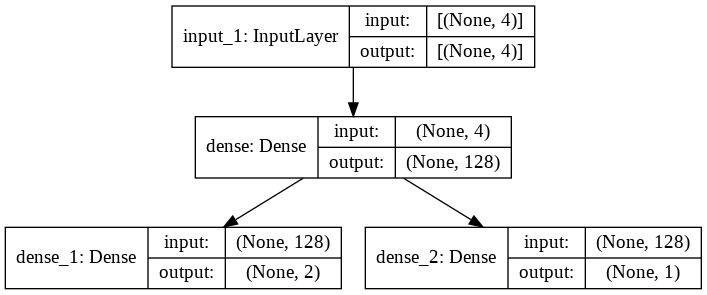

In [20]:
keras.backend.clear_session()

state_layer = layers.Input(shape=env.observation_space.shape)
common = layers.Dense(128, activation = 'relu')(state_layer)
action = layers.Dense(env.action_space.n, activation = 'softmax')(common)
critic = layers.Dense(1)(common)
model = keras.models.Model(inputs = state_layer, outputs=[action, critic])

plot_model(model, show_shapes=True)

In [21]:
gamma = 0.99  # Discount factor for past rewards
max_steps_per_episode = 10000
num_inputs = 4
num_actions = 2
eps = np.finfo(np.float32).eps.item() 

optimizer = keras.optimizers.Adam(learning_rate=0.01)
huber_loss = keras.losses.Huber()
action_probs_history = []
critic_value_history = []
rewards_history = []
running_reward = 0
episode_count = 0

while True:  # Run until solved
    env = wrap_env(gym.make("CartPole-v1"))
    state = env.reset()
    episode_reward = 0
    with tf.GradientTape() as tape:
        for timestep in range(1, max_steps_per_episode):
            # env.render(); Adding this line would show the attempts
            # of the agent in a pop up window.

            state = tf.convert_to_tensor(state)
            state = tf.expand_dims(state, 0)

            # Predict action probabilities and estimated future rewards
            # from environment state
            action_probs, critic_value = model(state)
            critic_value_history.append(critic_value[0, 0])

            # Sample action from action probability distribution
            action = np.random.choice(num_actions, p=np.squeeze(action_probs))
            action_probs_history.append(tf.math.log(action_probs[0, action]))

            # Apply the sampled action in our environment
            state, reward, done, _ = env.step(action)
            rewards_history.append(reward)
            episode_reward += reward

            if done:
                env.close()
                break

        # Update running reward to check condition for solving
        running_reward = 0.05 * episode_reward + (1 - 0.05) * running_reward

        # Calculate expected value from rewards
        # - At each timestep what was the total reward received after that timestep
        # - Rewards in the past are discounted by multiplying them with gamma
        # - These are the labels for our critic
        returns = []
        discounted_sum = 0
        for r in rewards_history[::-1]:
            discounted_sum = r + gamma * discounted_sum
            returns.insert(0, discounted_sum)

        # Normalize
        returns = np.array(returns)
        returns = (returns - np.mean(returns)) / (np.std(returns) + eps)
        returns = returns.tolist()

        # Calculating loss values to update our network
        history = zip(action_probs_history, critic_value_history, returns)
        actor_losses = []
        critic_losses = []
        for log_prob, value, ret in history:
            # At this point in history, the critic estimated that we would get a
            # total reward = `value` in the future. We took an action with log probability
            # of `log_prob` and ended up recieving a total reward = `ret`.
            # The actor must be updated so that it predicts an action that leads to
            # high rewards (compared to critic's estimate) with high probability.
            diff = ret - value
            actor_losses.append(-log_prob * diff)  # actor loss

            # The critic must be updated so that it predicts a better estimate of
            # the future rewards.
            critic_losses.append(
                huber_loss(tf.expand_dims(value, 0), tf.expand_dims(ret, 0))
            )

        # Backpropagation
        loss_value = sum(actor_losses) + sum(critic_losses)
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Clear the loss and reward history
        action_probs_history.clear()
        critic_value_history.clear()
        rewards_history.clear()

    # Log details
    episode_count += 1
    if episode_count % 10 == 0:
        template = "running reward: {:.2f} at episode {}"
        print(template.format(running_reward, episode_count))
    if episode_count % 20 == 0 :
        show_video()

    if running_reward > 195:  # Condition to consider the task solved
        print("Solved at episode {}!".format(episode_count))
        break

running reward: 12.48 at episode 10
running reward: 13.11 at episode 20


running reward: 12.63 at episode 30
running reward: 12.40 at episode 40


running reward: 13.22 at episode 50
running reward: 16.85 at episode 60


running reward: 28.74 at episode 70
running reward: 28.14 at episode 80


running reward: 36.03 at episode 90
running reward: 36.42 at episode 100


running reward: 36.34 at episode 110
running reward: 37.48 at episode 120


running reward: 38.77 at episode 130
running reward: 41.87 at episode 140


running reward: 53.81 at episode 150
running reward: 49.54 at episode 160


running reward: 53.85 at episode 170
running reward: 95.74 at episode 180


running reward: 185.05 at episode 190
Solved at episode 191!
